#Introduction

I have always taken an interest in how machine learning can be implemented into the medical field so for this project I will be using logistic regression to predict the risk of developing diabetes based on early symptoms and various other patient attributes. This is a good problem for logistic regression because the patient will either be positive or negative, meaning that we need to predict is a probability. Logistic regression returns numbers between 0 and 1 which we can map to probabilities, and then round to determine a decisive answer.


In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
## Reading the dataset

import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/Datasets/diabetes_risk_prediction_dataset.csv')
df.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive


#Exploratory Data Analysis

The first step in our Data analysis will be to determine exactly how many columns have miss entries as well as the number of unique labels in each column. This will determine if we will have to replace any missing entries, and how we will enode each column.

In [61]:
# determine the number of missing entries in each column
print(len(df) - df.count())

Age                   0
Gender                0
Polyuria              0
Polydipsia            0
sudden weight loss    0
weakness              0
Polyphagia            0
Genital thrush        0
visual blurring       0
Itching               0
Irritability          0
delayed healing       0
partial paresis       0
muscle stiffness      0
Alopecia              0
Obesity               0
class                 0
dtype: int64


In [62]:
# find the number of unique values in each column do determine which column can use binary encoding, and in which column
# might benefit from one hot encoding

df.nunique()

Age                   51
Gender                 2
Polyuria               2
Polydipsia             2
sudden weight loss     2
weakness               2
Polyphagia             2
Genital thrush         2
visual blurring        2
Itching                2
Irritability           2
delayed healing        2
partial paresis        2
muscle stiffness       2
Alopecia               2
Obesity                2
class                  2
dtype: int64

Luckily there are no missing entries so we don't have to worry about replacing any values. We also see that most of the columns have data that is binary, in that there are only two possible label. The only exception to this is Age which will have to be normalized, to avoid any numerical instability that arises from the wide range of values in the Age column.

One other thing that we will want to look for is the ratio of positive data points to negative datapoints. If there is a significant disproportion, then the training data will have to be modified to try ensure fairness when training the model.


In [63]:
from matplotlib import pyplot as plt

# determine the distribution of positive to negative classifications
p = df['class'].value_counts()['Positive']
n = df['class'].value_counts()['Negative']

print(f"Positive Cases: {p}\nNegative Cases: {n}")

Positive Cases: 320
Negative Cases: 200


<ipython-input-64-a6a12f4d2219>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(['class']).sum().plot(kind='pie', subplots=True, autopct='%1.0f%%')


(-1.25, 1.25, -1.25, 1.25)

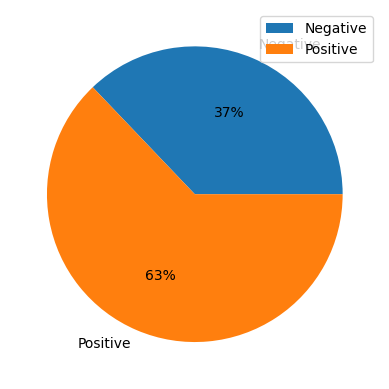

In [64]:
# make the plot
df.groupby(['class']).sum().plot(kind='pie', subplots=True, autopct='%1.0f%%')
plt.axis('off')

As we can see there are signifcantly more positive instances than there are negative ones, this means that we are going to have to find some way to balance the data.

#Data Modification

At this point we will simply be encoding the various columns and normalizing the Age column.

In [65]:
# take note of what what Positive and Negative encode to after binary encoding

c = df['class'].astype('category')
d = dict(enumerate(c.cat.categories))
print(d)

{0: 'Negative', 1: 'Positive'}


In [66]:
# convert the labels in each column to integer values instead
columns = df.columns
binary_columns = df.columns[1:] #these are columns with only two unique values in them

for column_name in binary_columns:
  df[column_name] = df[column_name].astype('category').cat.codes

df.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,1,0,1,0,1,0,0,0,1,0,1,0,1,1,1,1
1,58,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1
2,41,1,1,0,0,1,1,0,0,1,0,1,0,1,1,0,1
3,45,1,0,0,1,1,1,1,0,1,0,1,0,0,0,0,1
4,60,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1


In [67]:
# shuffle the dataset just to ensure a more or less even distribution of positive to negative cases
df = df.sample(frac = 1).reset_index(drop=True) #reset_index mainintains a sequential index ordering
df.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,55,0,1,1,1,1,0,0,1,0,0,0,1,0,0,1,1
1,35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,43,0,1,1,1,1,1,0,1,0,0,0,1,1,0,1,1
3,35,0,0,1,1,1,0,0,0,1,0,1,1,1,0,0,1
4,45,1,0,0,0,1,0,0,0,1,1,1,1,0,0,0,0


In [68]:
#mean normalize the age column
age_mean = df['Age'].mean()
age_std_dev = df['Age'].std()

df['Age'] = (df['Age'] - age_mean) / age_std_dev
df.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,0.573688,0,1,1,1,1,0,0,1,0,0,0,1,0,0,1,1
1,-1.072204,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,-0.413847,0,1,1,1,1,1,0,1,0,0,0,1,1,0,1,1
3,-1.072204,0,0,1,1,1,0,0,0,1,0,1,1,1,0,0,1
4,-0.249258,1,0,0,0,1,0,0,0,1,1,1,1,0,0,0,0


#Training Models and testing

In [69]:
#split the training data and testing data into seperate dataframes for features and targets

import math
import numpy as np
import time
import torch

X, y = df.drop(columns=['class']), df['class']

In [70]:
from numpy import mean
from numpy import std

from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

#initalize the boosted classifier model
model_1 = DecisionTreeClassifier(splitter = "random", max_depth = 11)

#use repeated stratified K fold in order to counter the imbalance in the data
cv_1 = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#run cross validation for each of the three metrics: accuracy, precision, and recall
n_scores_1_precision = cross_val_score(model_1, X, y, scoring='precision', cv=cv_1, n_jobs=-1, error_score='raise')
n_scores_1_recall = cross_val_score(model_1, X, y, scoring='recall', cv=cv_1, n_jobs=-1, error_score='raise')
n_scores_1_accuracy = cross_val_score(model_1, X, y, scoring='accuracy', cv=cv_1, n_jobs=-1, error_score='raise')

#average the accuracy, precision, and recall, and find the corresponding standard deviations
model_1_accuracy, model_1_accuracy_std = mean(n_scores_1_accuracy), std(n_scores_1_accuracy)
model_1_precision, model_1_precision_std = mean(n_scores_1_precision), std(n_scores_1_precision)
model_1_recall, model_1_recall_std = mean(n_scores_1_recall), std(n_scores_1_recall)

print('Accuracy: %.3f (%.3f)' % (model_1_accuracy, model_1_accuracy_std))

Accuracy: 0.970 (0.023)


In [71]:
from sklearn.ensemble import BaggingClassifier

#initialize the model
model_2 = BaggingClassifier(n_estimators = 10)

#use repeated stratified K fold in order to counter the imbalance in the data
cv_2 = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#run cross validation for each of the three metrics: accuracy, precision, and recall
n_scores_2_accuracy = cross_val_score(model_2, X, y, scoring='accuracy', cv=cv_2, n_jobs=-1, error_score='raise')
n_scores_2_precision = cross_val_score(model_2, X, y, scoring='precision', cv=cv_2, n_jobs=-1, error_score='raise')
n_scores_2_recall = cross_val_score(model_2, X, y, scoring='recall', cv=cv_2, n_jobs=-1, error_score='raise')

#average the accuracy, precision, and recall, and find the corresponding standard deviations
model_2_accuracy, model_2_accuracy_std = mean(n_scores_2_accuracy), std(n_scores_2_accuracy)
model_2_precision, model_2_precision_std = mean(n_scores_2_precision), std(n_scores_2_precision)
model_2_recall, model_2_recall_std = mean(n_scores_2_recall), std(n_scores_2_recall)

print('Accuracy: %.3f (%.3f)' % (model_2_accuracy, model_2_accuracy_std))

Accuracy: 0.969 (0.023)


In [72]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification

#initalize the boosted classifier model
model_3 = AdaBoostClassifier(n_estimators=4, random_state=0, algorithm='SAMME')

#use repeated stratified K fold in order to counter the imbalance in the data
cv_3 = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#run cross validation for each of the three metrics: accuracy, precision, and recall
n_scores_3_accuracy = cross_val_score(model_3, X, y, scoring='accuracy', cv=cv_3, n_jobs=-1, error_score='raise')
n_scores_3_precision = cross_val_score(model_3, X, y, scoring='precision', cv=cv_3, n_jobs=-1, error_score='raise')
n_scores_3_recall = cross_val_score(model_3, X, y, scoring='recall', cv=cv_3, n_jobs=-1, error_score='raise')

#average the accuracy, precision, and recall, and find the corresponding standard deviations
model_3_accuracy, model_3_accuracy_std = mean(n_scores_3_accuracy), std(n_scores_3_accuracy)
model_3_precision, model_3_precision_std = mean(n_scores_3_precision), std(n_scores_3_precision)
model_3_recall, model_3_recall_std = mean(n_scores_3_recall), std(n_scores_3_recall)

print('Accuracy: %.3f (%.3f)' % (model_3_accuracy, model_3_accuracy_std))

Accuracy: 0.834 (0.044)


In [73]:
print("TRAINING RESULTS:\n")

print("\tDecision Tree Classifier:\n\t\tPrecision: {:.2f}% ({:.3f})\n\t\tRecall: {:.2f}% ({:.3f})\n\t\tAccuracy: {:.2f}% ({:.3f})\n".format(model_1_precision * 100, model_1_precision_std * 100, model_1_recall * 100, model_1_recall_std * 100, model_1_accuracy * 100, model_1_accuracy_std * 100))
print("\tBagging Classifier:\n\t\tPrecision: {:.2f}% ({:.3f})\n\t\tRecall: {:.2f}% ({:.3f})\n\t\tAccuracy: {:.2f}% ({:.3f})\n".format(model_2_precision * 100, model_2_precision_std * 100, model_2_recall * 100, model_2_recall_std * 100, model_2_accuracy * 100, model_2_accuracy_std * 100))
print("\tBoosted Classifier:\n\t\tPrecision: {:.2f}% ({:.3f})\n\t\tRecall: {:.2f}% ({:.3f})\n\t\tAccuracy: {:.2f}% ({:.3f})\n".format(model_3_precision * 100, model_3_precision_std * 100, model_3_recall * 100, model_3_recall_std * 100, model_3_accuracy * 100, model_3_accuracy_std * 100))

TRAINING RESULTS:

	Decision Tree Classifier:
		Precision: 98.46% (2.219)
		Recall: 97.19% (2.188)
		Accuracy: 96.99% (2.312)

	Bagging Classifier:
		Precision: 98.16% (2.276)
		Recall: 97.29% (3.097)
		Accuracy: 96.92% (2.308)

	Boosted Classifier:
		Precision: 94.00% (3.970)
		Recall: 78.12% (6.038)
		Accuracy: 83.40% (4.371)



#METRICS

The three metrics used to guage the accuracy of these models were precision, recall and accuracy. Because this is a binary classification problem, it is  very important to guage how accurate the positive predictions are, and the number of positive predictions out of all the actuall positive predictions that our models are catching. This is why we are using recall and precision as metrics. The metrics of recall and precision also tell us more information than the raw accuracy score could.

  To demonstrate why it is important to use all three say for instance that we were using just accuracy to guage the models. We might think that the model is accurate if it returns say 80% but maybe, and especially in this scenario where the data is skewed toward postive data instances, the model only is able to get positive cases right. then even if the model is getting 80% it would still be a bad model. This is something that the precision metric could indicate to us, allowing us to try and resolve the issue.

#OBSERVATIONS

With regards to the first model, I did notice that setting the classifier to random managed to marginally increase the accuracy. I tried adjusting some of the other paramater including the max depth and criterion byt neither seemed to have a substantial effect.

With regards to the accruacy of the final two models, those begin the bagging and boosted classifiers. I was surprised to see that the boosted classifier performed considerably worse than the prior two models. In particular, the boosted classifier had a very poor recall.
